### Set up water network model

In this example, we test our quantum solvers into a slightly larger network as contained in `Net2Loops.inp`. Let's start by setting up the model:

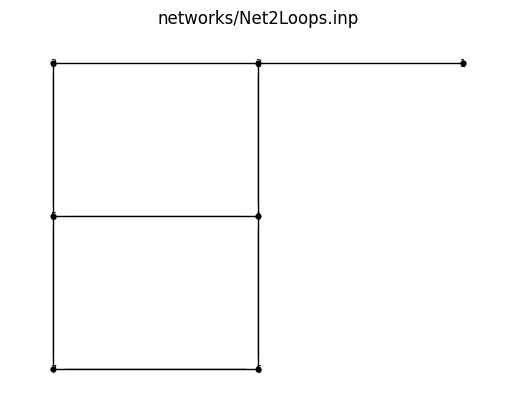

<Axes: title={'center': 'networks/Net2Loops.inp'}>

In [1]:
import os
import wntr
import wntr_quantum

os.environ["EPANET_TMP"] = "/Users/murilo/scratch_dir/.epanet_quantum"
os.environ["EPANET_QUANTUM"] = "/Users/murilo/Documents/NLeSC_Projects/Vitens/EPANET"

# set up network model
inp_file = 'networks/Net2Loops.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

# plot network
wntr.graphics.plot_network(wn, title=wn.name, node_labels=True)

# print options
# dict(wn.options.hydraulic)

### Solve model using the classical Epanet simulator

We now solve the same problem using the classical Epanet simulator. Note that, by default, `QuantumEpanetSimulator` uses a classical `CholeskySolver` to iteratively solve the linear problem.

In [2]:
import sys

# define the classical EPANET simulator
sim = wntr_quantum.sim.QuantumEpanetSimulator(wn)

# run the EPANET simulation
results_epanet = sim.run_sim()

# remember to set up EPANET Quantum environment variables!
epanet_path = os.environ["EPANET_QUANTUM"]
epanet_tmp = os.environ["EPANET_TMP"]

# check paths
print(f"Your EPANET quantum path: {epanet_path}")
print(f"Your EPANET temp dir: {epanet_tmp}\n")

util_path = os.path.join(epanet_path, 'src/py/')
sys.path.append(util_path)

from quantum_linsolve import load_json_data
epanet_A, epanet_b = load_json_data(os.path.join(epanet_tmp,'smat.json'))

# set the size of the Jacobian (A matrix)
epanet_A_dim = epanet_A.todense().shape[0]
print(f"Size of the Jacobian in EPANET simulator: {epanet_A_dim}")
print(f"Size of the b vector in EPANET simulator: {epanet_b.shape[0]}")

# save number of nodes and pipes
n_nodes = len(results_epanet.node["pressure"].iloc[0]), 
n_pipes = len(results_epanet.link["flowrate"].iloc[0])

results_epanet.node["pressure"], results_epanet.link["flowrate"]

Your EPANET quantum path: /Users/murilo/Documents/NLeSC_Projects/Vitens/EPANET
Your EPANET temp dir: /Users/murilo/scratch_dir/.epanet_quantum

Size of the Jacobian in EPANET simulator: 6
Size of the b vector in EPANET simulator: 6


(name          2          3          4          5          6          7  \
 0     53.247742  30.665516  44.321564  28.810593  30.547766  27.057959   
 
 name             1  
 0     4.394531e-07  ,
 name         1         2         3         4         5         6         7  \
 0     0.311088  0.051455  0.231865  0.031844  0.166692  0.075021  0.023685   
 
 name         8  
 0    -0.019471  )

### Solve linear system with VQLS and the final matrices from EPANET

For testing purposes, we start by solving the linear system with VQLS and the final A and b matrices from the classical EPANET simulator. Here, we are **preconditioning** the initial linear system using diagonal scaling and also using a **mix of two classical optimizers**.

In [3]:
import numpy as np

from qiskit.circuit.library import RealAmplitudes
from qiskit.primitives import Estimator
from qiskit_algorithms import optimizers as opt

from quantum_newton_raphson.vqls_solver import VQLS_SOLVER

n_qubits = int(np.ceil(np.log2(epanet_A_dim)))

qc = RealAmplitudes(n_qubits, reps=3, entanglement="full")
estimator = Estimator()

linear_solver = VQLS_SOLVER(
    estimator=estimator,
    ansatz=qc,
    optimizer=[opt.COBYLA(maxiter=1000, disp=True), opt.CG(maxiter=500, disp=True)],
    matrix_decomposition="symmetric",
    verbose=True,
    preconditioner="diagonal_scaling",
)

res = linear_solver(epanet_A, epanet_b)

VQLS Iteration 1000 Cost 7.080e-02
   Return from subroutine COBYLA because the MAXFUN limit has been reached.

   NFVALS = 1000   F = 7.079738E-02    MAXCV = 0.000000E+00
   X = 3.050961E+00  -5.065668E-01   6.475237E-01  -3.878474E-01  -1.035223E+00
       9.289326E-01   4.749921E+00   1.107448E+00  -2.793952E+00  -2.999772E+00
      -1.852907E+00   1.365128E+00
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 67
         Function evaluations: 1469
         Gradient evaluations: 113


Let's check the evolution of the cost function

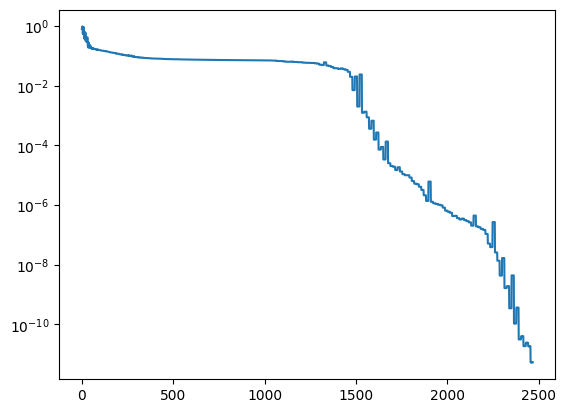

In [4]:
import matplotlib.pyplot as plt
plt.semilogy(res.logger.values)

and visualize graphically the solution

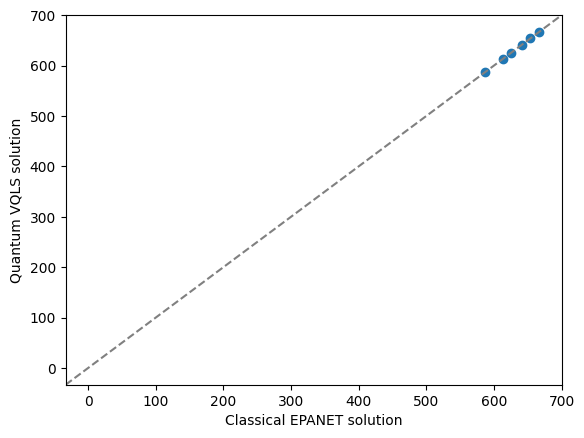

(array([613.707, 641.561, 653.942, 666.823, 625.543, 586.649]),
 array([613.706, 641.559, 653.94 , 666.822, 625.543, 586.648]))

In [5]:
import numpy as np 
ref = np.linalg.solve(epanet_A.todense(), epanet_b)

plt.scatter(ref, res.solution)
plt.axline((0, 0), slope=1, linestyle="--", color="gray")
plt.xlabel("Classical EPANET solution")
plt.ylabel("Quantum VQLS solution")
plt.show()

ref, res.solution